### Open data file and study general information

In [ ]:
!pip install squarify
import squarify
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

# Open data files
data = pd.read_csv('/datasets/games.csv')

# Study general information
data.info()

Defaulting to user installation because normal site-packages is not writeable
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Study the general information:

There is one table, which I've named data. It has 11 columns, currently of type object and float datatypes. There are 16,715 entries in the entire table. The following columns have less than 16,715 non-null rows: Year_Of_Release, Genre, Critic_Score, User_Score, Rating - this means that they have null values which need to be either dropped or filled (to be decided later). There are 11,560 unique games in this database. 

### Data Preprocessing

In [ ]:
# Make the column names lowercase
data.columns = data.columns.str.lower()

#genre column: convert to string type, Drop rows with 'nan' values
data['genre'] = data['genre'].astype(str)
data.drop(data[data['genre'] == 'nan'].index,inplace=True)
            
# dropped rows with no sales
data.drop(data[(data['na_sales'] == 0) & (data['eu_sales'] == 0) & (data['jp_sales'] == 0) & (data['other_sales'] == 0)].index,inplace=True)

# Drop any duplicates in the database
data.drop_duplicates(inplace=True)

I started my making all the column names lowercase using the lower() method. 

I found no data type problems or missing values in the name, platform, na_sales, eu_sales, jp_sales, other_sales columns.

For the 'genre' column, there was two rows with 'nan' values for genre. They also had NaN valuesfor other columns, so I decided to drop these two rows. 

I decided to drop the rows with no NA,JP, EU and Other sales. There were only two of these rows and most of their other values were either 0  or NaN. 

I dropped any duplicates present in the database. 

In [ ]:
# year_of_release column: Replace rows 'nan' values in the year_of_release column based on if the game already exists 
data['year_of_release'] = data['year_of_release'].fillna(value=0)
missingYearRows = data[data['year_of_release'] == 0.0]
missingYearRows['index'] =  missingYearRows.index.tolist()
for index,row in missingYearRows.iterrows():
    name = row['name']
    year = 0
    originalIndex = row['index']
    matchingNameRows = data.query('name == @name')
    for index1, row1 in matchingNameRows.iterrows():
        if row1['name'] is not 0.0:
            year = row1['year_of_release']
            data.loc[originalIndex,'year_of_release'] = year
            break

# Drop rows whose year_of_release wasn't filled from table
data.drop(data[data['year_of_release'] == 0.0].index, inplace=True)
data.reset_index()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


index                           name platform  year_of_release  \
0          0                     Wii Sports      Wii           2006.0   
1          1              Super Mario Bros.      NES           1985.0   
2          2                 Mario Kart Wii      Wii           2008.0   
3          3              Wii Sports Resort      Wii           2009.0   
4          4       Pokemon Red/Pokemon Blue       GB           1996.0   
...      ...                            ...      ...              ...   
16515  16710  Samurai Warriors: Sanada Maru      PS3           2016.0   
16516  16711               LMA Manager 2007     X360           2006.0   
16517  16712        Haitaka no Psychedelica      PSV           2016.0   
16518  16713               Spirits & Spells      GBA           2003.0   
16519  16714            Winning Post 8 2016      PSV           2016.0   

              genre  na_sales  eu_sales  jp_sales  other_sales  critic_score  \
0            Sports     41.36     28.96      3.77         8.45          76.0   
1          Platform     29.08      3.58      6.81         0.77           NaN   
2            Racing     15.68     12.76      3.79         3.29          82.0   
3            Sports     15.61     10.93      3.28         2.95          80.0   
4      Role-Playing     11.27      8.89     10.22         1.00           NaN   
...             ...       ...       ...       ...          ...           ...   
16515        Action      0.00      0.00      0.01         0.00           NaN   
16516        Sports      0.00      0.01      0.00         0.00           NaN   
16517     Adventure      0.00      0.00      0.01         0.00           NaN   
16518      Platform      0.01      0.00      0.00         0.00           NaN   
16519    Simulation      0.00      0.00      0.01         0.00           NaN   

      user_score rating  
0              8      E  
1            NaN    NaN  
2            8.3      E  
3              8      E  
4            NaN    NaN  
...          ...    ...  
16515        NaN    NaN  
16516        NaN    NaN  
16517        NaN    NaN  
16518        NaN    NaN  
16519        NaN    NaN  

[16520 rows x 12 columns]

For the 'year_of_release' column, there are 269 rows with a null value in that column. I noticed that some of these nulls are games who have valid years in other rows so I replaced those NaN values with the actual game release year if the game exists. I did this by iterating through the database, filling null values with 0s, identifying all the rows with year_of_release set to 0 within its individual dataframe and adding the index of these rows to a column named 'index' within this new dataframe. I iterated through each of these rows with year_of_release set to 0, checked if the name of the game matched the name of another game with a non null year_of_release and if it did, I updated the absent year with that discovered year. 

Only 78/269 rows with missing year_of_release values were filled with valid years found within the data set. This means that there are still 191 rows with null year_of_release. I decided to drop these rows because 191 rows out of the entire 16715 row data is only 1.1% of data, which is less than 10% and therefore will not make a big impact on analysis. 

In [ ]:
# 'critic_score' column: replace relevant nan with average of critic scores of the same games
data['critic_score'] = data.groupby('name')['critic_score'].transform(lambda grp: grp.fillna(np.mean(grp)))

For the 'critic_score' column, I found 8576/16715 (51.3%) rows with null values, which is more than half so I will not drop these. I used the transform function to replace the relevant the null values with the average of the critic scores for the same game name. This function works by grouping by the name of the game and retrieving the median of the critic score values for each group, then assigning that mean critic score value to any rows who have a matching game name.  Only 961/8574 (11.2%) rows had their critic score filled in using the average from other entires, the remaining 7615 rows were left as critic score being null.

In [ ]:
# 'user_score' column: fill 'tbd' values with nan, replace relevant nan with average of user scores of the same games
data['user_score'] = data['user_score'].replace('tbd',None)
data['user_score'] = data['user_score'].astype(float)
data['user_score'] = data.groupby('name')['user_score'].transform(lambda grp: grp.fillna(np.mean(grp)))

For the 'user_score' column, I found 7951/16715 (47.6%) rows with either null or 'tbd' values, which is enough to not drop these. I replaced the 'tbd' values with None values, since no one is going to update this dataset with user scores. I casted every value in the user_score column to floats for standardization. I used the transform function to replace the relevant the null values with the average of the user scores for the same game name.  This function works by grouping by name of the game and retrieving the mean of the user score values for each group, then assigning that median user score value to any rows who have a matching game name. Only 905/7951 (11.3%) rows had their user scores filled in using the avergae from other entires, the remaining 7046 rows were left as user score being null.

In [ ]:
# 'rating' column: fill null values with most frequenctly occuring rating in its genre
data['rating'] = data.groupby('genre')['rating'].transform(lambda grp: grp.fillna(grp.mode().iloc[0]))

For the 'rating' column, I found 6762/16715 (40.4%) rows with null values, which is enough to not drop them. I used the transform function to replace null values with the most occuring rating in the same genre of the game. This function works by grouping by genre and retrieving the median of the rating values for each group, then assigning that median rating value to any rows who have a matching genre. 

###  Add to the table the sum of sales in all regions for each game

In [ ]:
# Calculate the sum of sales in all regions for each game and put these values in a separate column
data['total_sales'] = data[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis=1)
display(data)

name platform  year_of_release         genre  \
0                         Wii Sports      Wii           2006.0        Sports   
1                  Super Mario Bros.      NES           1985.0      Platform   
2                     Mario Kart Wii      Wii           2008.0        Racing   
3                  Wii Sports Resort      Wii           2009.0        Sports   
4           Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing   
...                              ...      ...              ...           ...   
16710  Samurai Warriors: Sanada Maru      PS3           2016.0        Action   
16711               LMA Manager 2007     X360           2006.0        Sports   
16712        Haitaka no Psychedelica      PSV           2016.0     Adventure   
16713               Spirits & Spells      GBA           2003.0      Platform   
16714            Winning Post 8 2016      PSV           2016.0    Simulation   

       na_sales  eu_sales  jp_sales  other_sales  critic_score  user_score  \
0         41.36     28.96      3.77         8.45          76.0         8.0   
1         29.08      3.58      6.81         0.77           NaN         NaN   
2         15.68     12.76      3.79         3.29          82.0         8.3   
3         15.61     10.93      3.28         2.95          80.0         8.0   
4         11.27      8.89     10.22         1.00           NaN         NaN   
...         ...       ...       ...          ...           ...         ...   
16710      0.00      0.00      0.01         0.00           NaN         NaN   
16711      0.00      0.01      0.00         0.00           NaN         NaN   
16712      0.00      0.00      0.01         0.00           NaN         NaN   
16713      0.01      0.00      0.00         0.00           NaN         NaN   
16714      0.00      0.00      0.01         0.00           NaN         NaN   

      rating  total_sales  
0          E        82.54  
1          E        40.24  
2          E        35.52  
3          E        32.77  
4          T        31.38  
...      ...          ...  
16710      T         0.01  
16711      E         0.01  
16712      E         0.01  
16713      E         0.01  
16714      E         0.01  

[16520 rows x 12 columns]

I calculated the total sales for each game by slicing the sales columns and summing them all into one  column, called sum_sales

### Examine how many games were released in different years

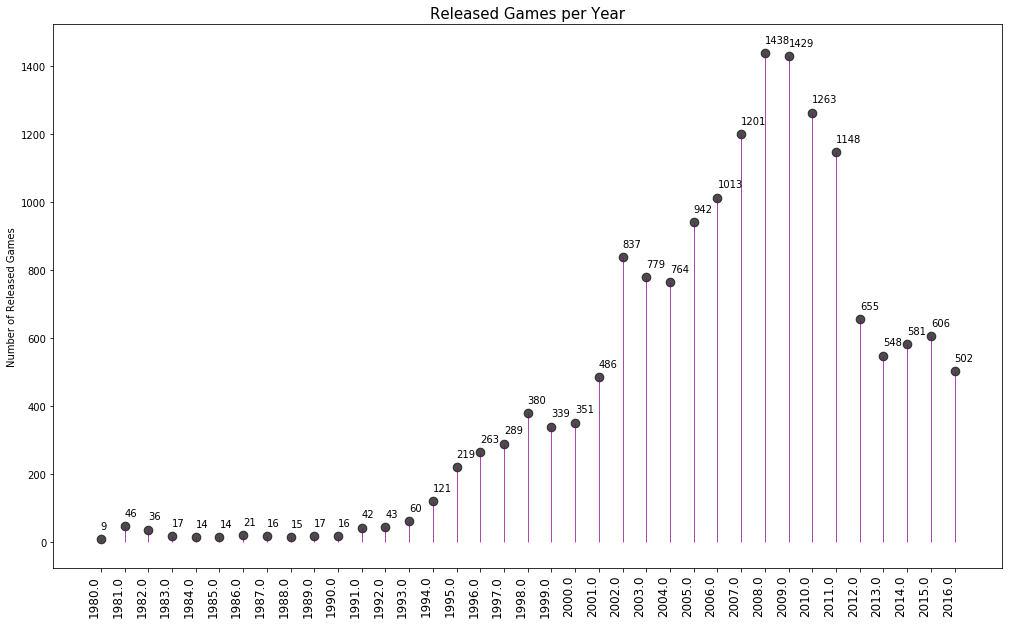

In [ ]:
# Look at how many games were released in different years. Is the data for every period significant?

yearGames = data[['year_of_release','name']].groupby('year_of_release').count().sort_values(by='year_of_release').reset_index()
yearGames.columns = ['year_of_release','total_games']
yearGames = yearGames[yearGames['year_of_release'] != 0]
#display(yearGames)

fig, ax = plt.subplots(figsize=(17,10))
ax.vlines(x=yearGames.year_of_release, ymin=0, ymax=yearGames.total_games,color='purple',alpha=0.7,linewidth=1)
ax.scatter(x=yearGames.year_of_release,y=yearGames.total_games, s=75, color='black',alpha=0.7)

ax.set_title("Released Games per Year", fontdict={'size':15})
ax.set_ylabel('Number of Released Games')
ax.set_xticks(yearGames.year_of_release)
ax.set_xticklabels(yearGames.year_of_release, rotation=90, fontdict={'horizontalalignment':'right','size':12})
for row in yearGames.itertuples():
    ax.text(row.year_of_release, row.total_games+30,s=round(row.total_games,2))

To look at how many games were released in different years, I created a lollipop graph that shows the number of games (on y axis) released for every year (on x axis) in the data set. The data before 2000 seems less significant than the data after 2000 as only in 2003 do the number of released games really jump up. 

### Examine how sales varied from platform to platform

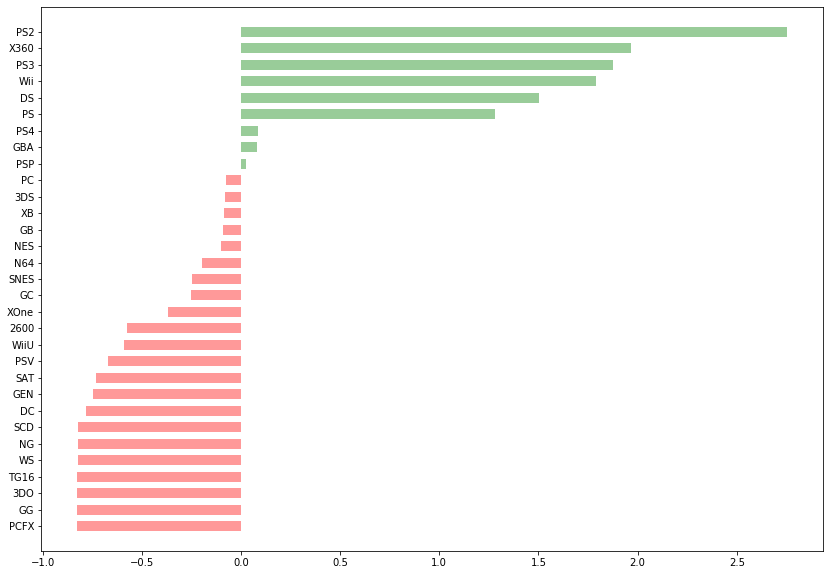

In [ ]:
# Look at how sales varied from platform to platform. 
salesPlatform = data[['platform','total_sales']].groupby('platform').sum().sort_values(by='total_sales').reset_index()
salesPlatform['sales_zscore'] = (salesPlatform['total_sales'] - salesPlatform['total_sales'].mean())/ salesPlatform['total_sales'].std()
salesPlatform['color'] = ['red' if x<0 else 'green' for x in salesPlatform['sales_zscore']]

plt.figure(figsize=(14,10))
plt.hlines(y=salesPlatform.platform, xmin=0, xmax=salesPlatform.sales_zscore, colors=salesPlatform.color, alpha=0.4, linewidth=10)

To look at sales varied from platform to platform, I built a divergence plot using the zscore which tells the distribution from the average total sales each platform total sales is. I subtracted the average of total sales from the total sales of that platform and divided it by the standard deviation to determine the z-score of each platform. The platforms with negative z-scores (in red) are platforms whose total sales are less than the average total sales for all platforms and the ones with positive z-score (in green) are platforms whose total sales are greater than the average total sales for all platforms. The platforms with the greatest total sales are the PS2, X360, PS3, Wii, DS and PS.  

### Identify platforms with greatest total sales

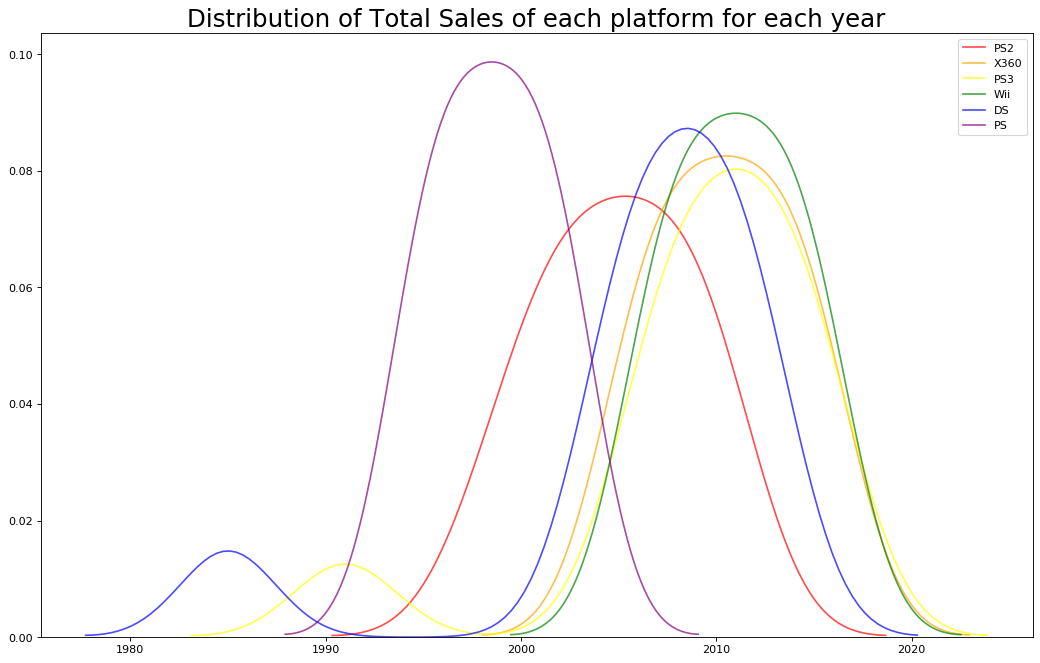

In [ ]:
# Choose the platforms with the greatest total sales and build a distribution based on data for each year. 
greatestTotalSalesPlatforms = salesPlatform.sort_values(by='total_sales', ascending=False).head(6)['platform'].tolist()
greatestTotalSales = data.query('platform in @greatestTotalSalesPlatforms')[['platform','year_of_release','total_sales']]
greatestTotalSales = pd.pivot_table(greatestTotalSales, values=['total_sales'],index=['platform','year_of_release'],aggfunc='sum').reset_index()
greatestTotalSales = greatestTotalSales[greatestTotalSales['year_of_release']!=0]

plt.figure(figsize=(16,10), dpi= 80)
colors = ['red','orange','yellow','green','blue','purple']
i=0
for platform in greatestTotalSalesPlatforms:
    platData = greatestTotalSales.loc[greatestTotalSales['platform'] == platform, 'year_of_release']
    sns.kdeplot(platData, shade=False , color=colors[i], label=platform, alpha=0.7)
    i += 1

plt.title('Distribution of Total Sales of each platform for each year', fontsize=22)
plt.legend()
plt.show()

The platforms with the greatest total sales are the PS2, X360, PS3, Wii, DS and PS (top 6 platforms). To build a distribution based on data for each year, I built a density histogram that shows the distribution of total sales per year for each platform.

### Identify platforms that used to be popular but now have 0 sales

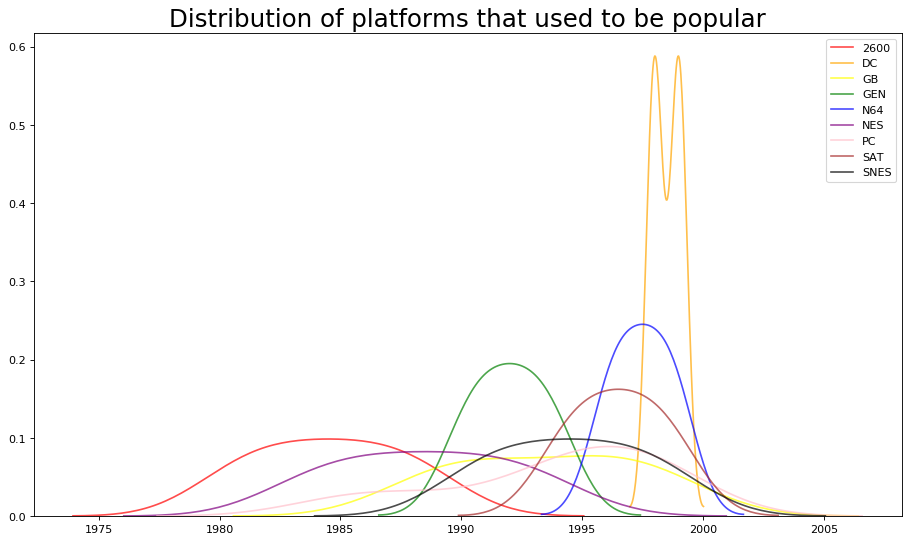

In [ ]:
# Find platforms that used to be popular but now have zero sales. 
lowestTotalSalesPlatforms = salesPlatform[(salesPlatform['sales_zscore'] < 0) & (salesPlatform['total_sales'] > 15.00)]['platform'].tolist()
lowestTotalSales = data.query('platform in @lowestTotalSalesPlatforms')[['platform','year_of_release','total_sales']]
lowestTotalSales = pd.pivot_table(lowestTotalSales, values=['total_sales'],index=['platform','year_of_release'],aggfunc='sum').reset_index()
lowestTotalSales = lowestTotalSales[(lowestTotalSales['year_of_release']!=0) & (lowestTotalSales['year_of_release'] < 2000)]

plt.figure(figsize=(14,8), dpi= 80)
colors = ['red','orange','yellow','green','blue','purple','pink','brown','black','magenta','gray','deeppink']
i=0
for platform in lowestTotalSales['platform'].unique():
    platData = lowestTotalSales.loc[lowestTotalSales['platform'] == platform, 'year_of_release']
    sns.kdeplot(platData, shade=False , color=colors[i], label=platform, alpha=0.7)
    i += 1

plt.title('Distribution of platforms that used to be popular', fontsize=22)
plt.legend()
plt.show()

To find the playforms that used to be popular but now have zero sales, I identified platforms who have a negative z-score, a high total sales amount and who have a year of release less than 2000 (they haven't been released in the past 15 years). From these, I plotted the distribution of the platforms and it shows that all of these stopped havig sales by 2005. 

### How long does it take for new platforms to appear and old ones to fade?

In [ ]:
# How long does it generally take for new platforms to appear and old ones to fade?
fadeTimePerPlatform = (lowestTotalSales.groupby('platform')['year_of_release'].max() - lowestTotalSales.groupby('platform')['year_of_release'].min()).reset_index()
averageFadeTime = fadeTimePerPlatform['year_of_release'].mean().round(decimals=1)
print(averageFadeTime)

7.4


The average time it takes for new platforms to appear and old ones to fade is about 7.4 years.

### Determine what period to take data from.

In [ ]:
# Work only with the data that you've decided is relevant. 
data = data[data['year_of_release'] >= 2005]

To determine what period to take data from in order to plan a campaign for 2017, we should take data from the last 10 years beforehand. I will keep data with a year_of_release greater than 2005. 

### Determine which platforms are leading in sales.

Text(0.5, 1.0, 'Distribution of Platform Market')

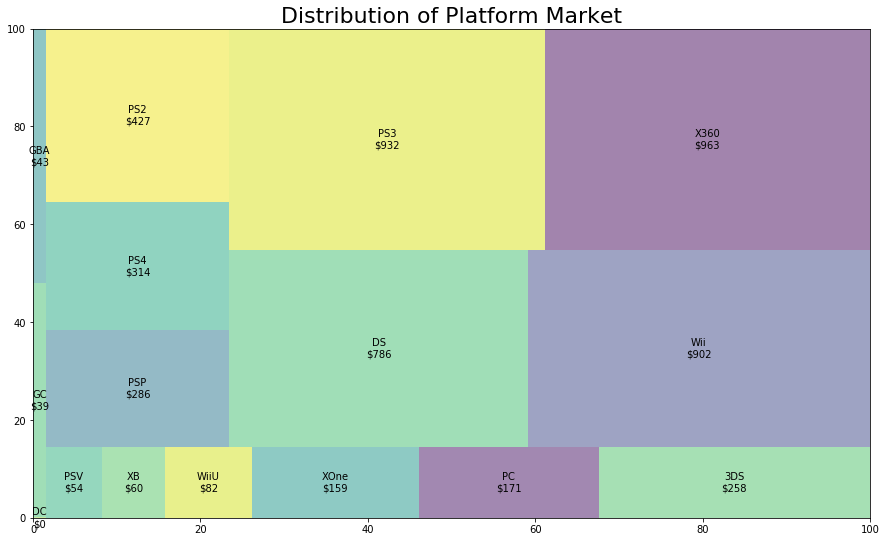

In [ ]:
# Which platforms are leading in sales? 
salesData = data[['platform','total_sales']].groupby('platform').sum().sort_values(by='total_sales').reset_index()
salesData = salesData[salesData['total_sales'] != 0]
sizes = salesData.total_sales.values.tolist()
labels = salesData.apply(lambda x: str(x[0]) + "\n" + "$" + str(round(x[1])),axis=1)
plt.figure(figsize=(15,9))
squarify.plot(sizes=sizes,label=labels,alpha=0.5)

plt.title('Distribution of Platform Market', fontsize=22)

This tree map shows the distribution of the market. The platforms that are leading in sales include PS3, X360, DS and Wii.

### Determine which platforms are growing and which are shrinking.

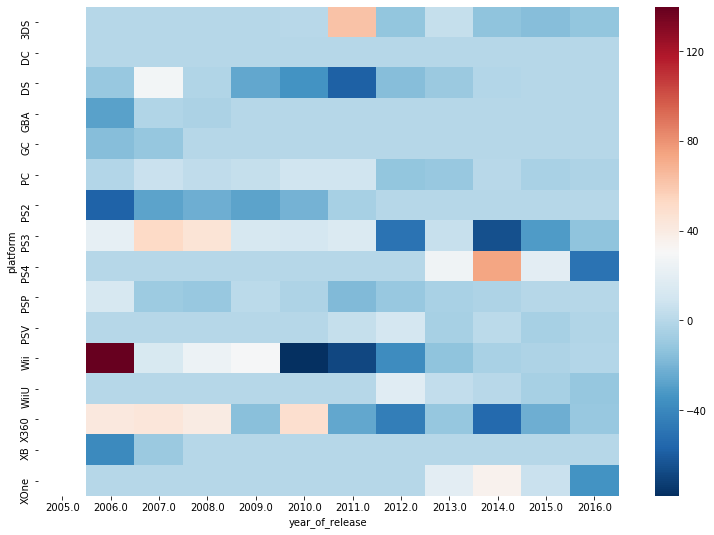

In [ ]:
# Which ones are growing or shrinking? Select several potentially profitable platforms.
growData = pd.pivot_table(data, index='year_of_release', columns='platform',values='total_sales',aggfunc='sum',fill_value=0)
dynamics = growData - growData.shift(+1)
#display(dynamics)
plt.figure(figsize=(13,9))
sns.heatmap(dynamics.T,cmap='RdBu_r')

This heat map shows the sales success or drop of each platform per year. It shows the peak sales, increase in sales or decrease in sales for each platform where red means increase and blue means decrease. The platforms that are shrinking are PSV, PS2, DS, Wii. The platforms that are growing are PS4, XOne, PS3. Some potentially profitable platforms include PS4, X360, XOne.

### Build a plot for the global sales of all games, broken down by platform.

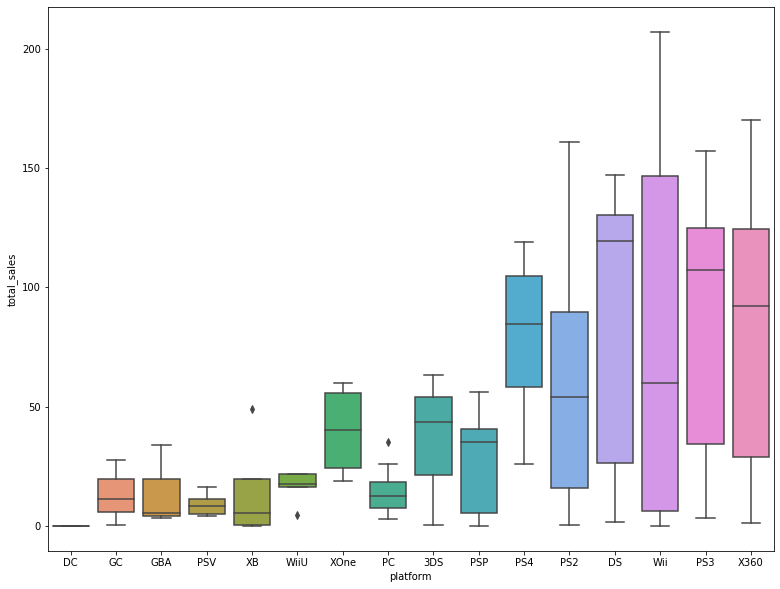

In [ ]:
# Build a box plot for the global sales of all games, broken down by platform. 
# Are the differences in sales significant? What about average sales on various platforms? 

globalSales = data.groupby(['platform','year_of_release'])['total_sales'].sum().reset_index()
ordered = globalSales.groupby(['platform'])['total_sales'].sum().sort_values().reset_index()['platform']
plt.figure(figsize=(13,10))
sns.boxplot(x='platform',y='total_sales',data=globalSales,order=ordered)

I have built a box plot for the global sales of games, brokwn down by platform. The differences in sales are significant - the games sold on X360, PS3, Wii, DS, PS2 and PS4 are more profitable than the games sold on PSP, 3DS, PC, XOne, etc. 

In terms of average sales over the 10 year period between 2005-2016: the average sales on X360, PS3, DS, and PS4 are the most comparable, then the average sales on Wii, PS2 are comparable, then the average sales on PSP, 3DS and XOne are comparable, and finally the rest have the lowest average sales.

### Examine the correlation between user / critic reviews and sales.

Correlation between critic score and total sales for X360 is: 0.23
Correlation between user score and total sales for X360 is: 0.08


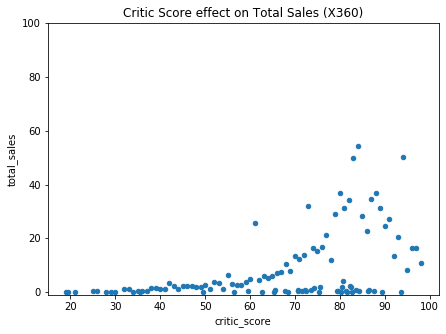

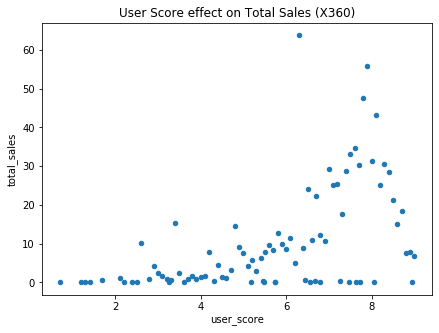

In [ ]:
# Take a look at how user and professional reviews affect sales for one popular platform (you choose). 
x360Data = data[data['platform'] == 'X360']

# Build a scatter plot and calculate the correlation between reviews and sales. Draw conclusions.
x360DataCritic = x360Data.groupby(['critic_score'])['total_sales'].sum().reset_index()
axCritic = x360DataCritic.plot.scatter(x='critic_score', y='total_sales', ylim=(-1,100),figsize=(7,5))
axCritic.set_title('Critic Score effect on Total Sales (X360)')
criticCorrelation = data['critic_score'].corr(data['total_sales'])
print('Correlation between critic score and total sales for X360 is: ' + str(criticCorrelation.round(decimals=2)))

x360DataUser = x360Data.groupby(['user_score'])['total_sales'].sum().reset_index()
axUser = x360DataUser.plot.scatter(x='user_score', y='total_sales',figsize=(7,5))
axUser.set_title('User Score effect on Total Sales (X360)')
userCorrelation = data['user_score'].corr(data['total_sales'])
print('Correlation between user score and total sales for X360 is: ' + str(userCorrelation.round(decimals=2)))

I chose the X360 as a popular platform to compare how professional critic scores and user scores affect its total sales. I found that both critic score and user score affect the total sales, as the higher the score given to the game on the platform then the higher the total sales. 

When looking at the correlation values, the user score correlation values (0.08) is much lower than the critic score correlation value (0.23). Buyers seem to trust professional criticers more than the average buyer.

### Compare the sales of the same games on other platforms.

Average correlation between critic score and total sales for (PS2,PS3,PS4,Wii) is: 0.35
Average correlation between user score and total sales for (PS2,PS3,PS4,Wii) is: 0.29


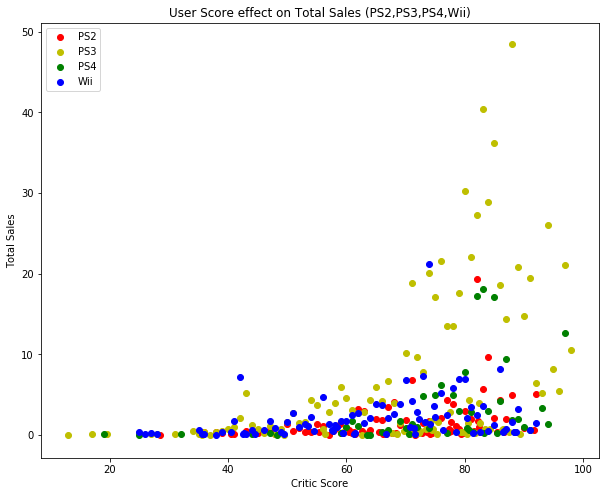

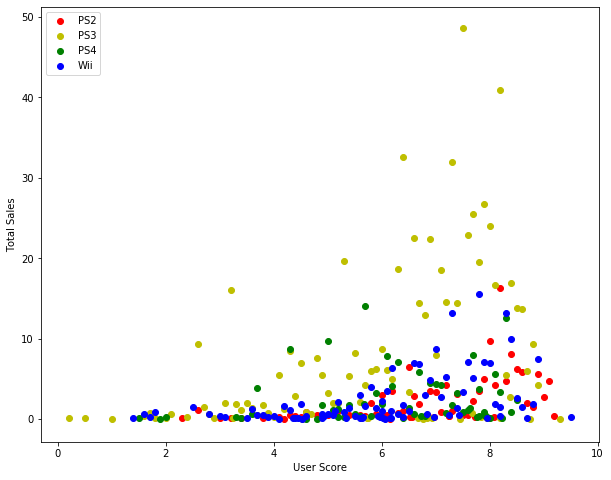

In [ ]:
# Compare the sales of the same games on other platforms.
x360Games = x360Data['name'].unique().tolist()

sameGamesOtherPlatforms = data.query('platform != "X360" and name in @x360Games')
sameGamesOtherPlatforms = sameGamesOtherPlatforms.query('platform in ("PS2","PS3","PS4","Wii")')

sameGamesOtherPlatformsCritic = sameGamesOtherPlatforms.groupby(['platform','critic_score'])['total_sales'].sum().reset_index()
fig, axCritic = plt.subplots(figsize=(10,8))
platforms = ["PS2","PS3","PS4","Wii"]
colors = ['r','y','g','b']
i =0
for p in platforms:
    d = sameGamesOtherPlatformsCritic[sameGamesOtherPlatformsCritic['platform'] == p]
    axCritic.scatter(d['critic_score'],d['total_sales'],c=colors[i],label=p)
    i+=1
axCritic.legend(loc='upper left')
axCritic.set_title("Critic Score effect on Total Sales (PS2,PS3,PS4,Wii)")
axCritic.set_xlabel('Critic Score')
axCritic.set_ylabel('Total Sales')
criticCorrelation = sameGamesOtherPlatformsCritic['critic_score'].corr(sameGamesOtherPlatformsCritic['total_sales'])
print('Average correlation between critic score and total sales for (PS2,PS3,PS4,Wii) is: ' + str(criticCorrelation.round(decimals=2)))

sameGamesOtherPlatformsUser = sameGamesOtherPlatforms.groupby(['platform','user_score'])['total_sales'].sum().reset_index()
fig, axUser = plt.subplots(figsize=(10,8))
platforms = ["PS2","PS3","PS4","Wii"]
colors = ['r','y','g','b']
i =0
for p in platforms:
    d = sameGamesOtherPlatformsUser[sameGamesOtherPlatformsUser['platform'] == p]
    axUser.scatter(d['user_score'],d['total_sales'],c=colors[i],label=p)
    i+=1
axUser.legend(loc='upper left')
axCritic.set_title("User Score effect on Total Sales (PS2,PS3,PS4,Wii)")
axUser.set_xlabel('User Score')
axUser.set_ylabel('Total Sales')
criticCorrelation = sameGamesOtherPlatformsUser['user_score'].corr(sameGamesOtherPlatformsUser['total_sales'])
print('Average correlation between user score and total sales for (PS2,PS3,PS4,Wii) is: ' + str(criticCorrelation.round(decimals=2)))


I chose the PS2, PS3, PS4, Wii as other popular platforms to compare how professional critic scores and user scores affect its total sales. I found that both critic score and user score affect the total sales, as the higher the score given to the game on the platform then the higher the total sales. However, when looking at the correlation values, the user score correlation value (0.30) is lower than the critic score correlation value (0.35). This was the opposite when I was looking at just the X360.

### Examine the general distribution of games by genre. 

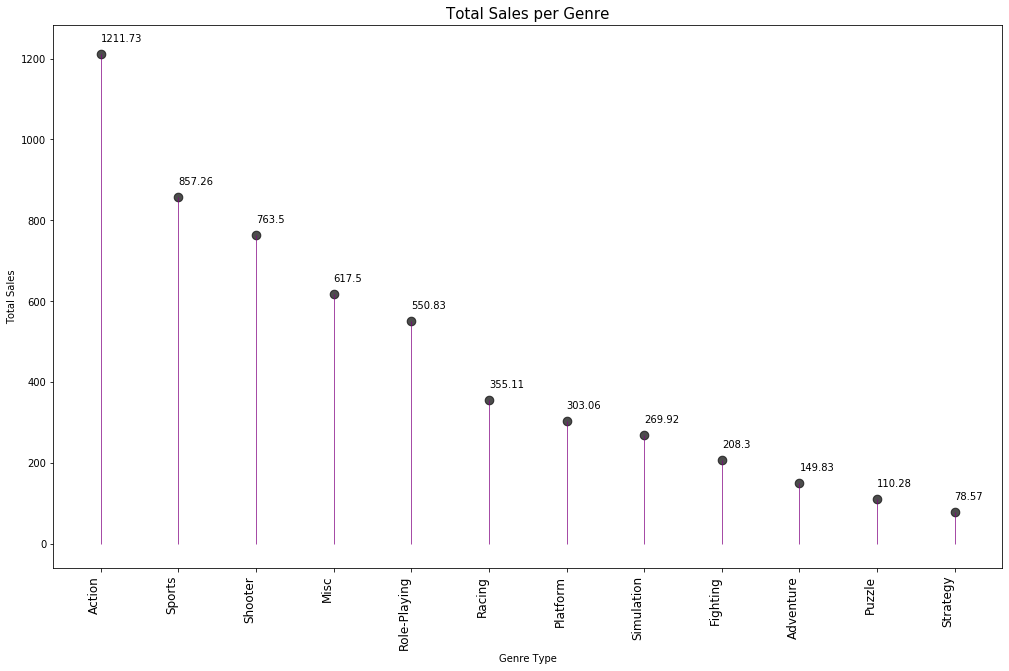

In [ ]:
# Take a look at the general distribution of games by genre. 
# What can we say about the most profitable genres? 

genreData = data[['genre','total_sales']].groupby(['genre']).sum().sort_values(by='total_sales',ascending=False).reset_index()
fig, ax = plt.subplots(figsize=(17,10))
ax.vlines(x=genreData.genre, ymin=0, ymax=genreData.total_sales,color='purple',alpha=0.7,linewidth=1)
ax.scatter(x=genreData.genre,y=genreData.total_sales, s=75, color='black',alpha=0.7)

ax.set_title("Total Sales per Genre", fontdict={'size':15})
ax.set_ylabel('Total Sales')
ax.set_xlabel('Genre Type')
ax.set_xticks(genreData.genre)
ax.set_xticklabels(genreData.genre, rotation=90, fontdict={'horizontalalignment':'right','size':12})
for row in genreData.itertuples():
    ax.text(row.genre, row.total_sales+30,s=round(row.total_sales,2))


The most profitable genre are action (USD 1211.73 million), sports (USD 857.27 million), shooter (USD 763.5 million) and role-playing (USD 550.83 million). 

### Examine genres with high and low sales on 3 platforms.

[236.8, 14.9, 37.3, 89.0, 11.3, 0.7, 64.1, 71.4, 276.4, 13.9, 137.3, 9.7]

Text(0, 0.5, 'Total Sales')

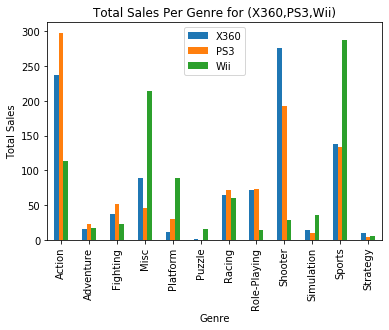

In [ ]:
# What can you generalize about genres with high and low sales?
profitablePlatforms = ['X360','PS3','Wii']
genrePlatform = data.query('platform in @profitablePlatforms')
genrePlatform = genrePlatform[['platform','genre','total_sales']].groupby(['platform','genre']).sum().sort_values(by='genre').reset_index()
genreList = genrePlatform['genre'].unique().tolist()

x360 = []
ps3 = []
wii = []
for genre in genreList:
    x360.append(genrePlatform[(genrePlatform['platform'] == "X360") & (genrePlatform['genre'] == genre)]['total_sales'].values[0].round(decimals=1))
    ps3.append(genrePlatform[(genrePlatform['platform'] == "PS3") & (genrePlatform['genre'] == genre)]['total_sales'].values[0].round(decimals=1))
    wii.append(genrePlatform[(genrePlatform['platform'] == "Wii") & (genrePlatform['genre'] == genre)]['total_sales'].values[0].round(decimals=1))
display(x360)

plotdata = pd.DataFrame({
    "X360":x360,
    "PS3":ps3,
    "Wii":wii
    }, 
    index=genreList
)
plotdata.plot(kind="bar")
plt.title("Total Sales Per Genre for (X360,PS3,Wii)")
plt.xlabel("Genre")
plt.ylabel("Total Sales")

Genres with low sales (such as puzzle, strategy, adventure, fighting, simulation) are low selling genres across the most popular platforms. Genres with high sales (such as action, misc, shooter, sports) are high selling genres across the most popular platforms. 

### Examine the top 5 platforms per region (EU, NA, JP)

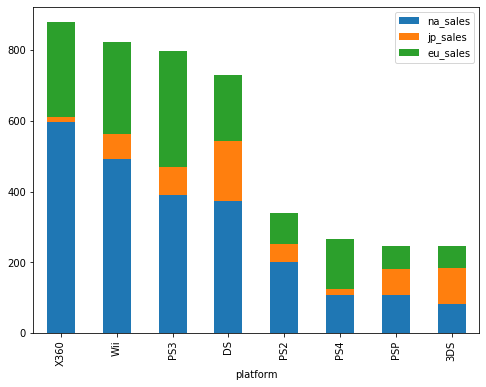

In [ ]:
#For each region (NA, EU, JP), determine:

naData = data[['platform','genre','rating','na_sales']]
jpData = data[['platform','genre','rating','jp_sales']]
euData =  data[['platform','genre','rating','eu_sales']]

#The top five platforms. Describe variations in their market shares from region to region
naPlatforms = naData.groupby('platform').sum().sort_values(by='na_sales',ascending=False)
jpPlatforms = jpData.groupby('platform').sum().sort_values(by='jp_sales',ascending=False)
euPlatforms = euData.groupby('platform').sum().sort_values(by='eu_sales',ascending=False)
totalPlatforms = np.unique(np.array(naPlatforms.reset_index().head(5)['platform'].tolist()+jpPlatforms.reset_index().head(5)['platform'].tolist()+euPlatforms.reset_index().head(5)['platform'].tolist()))

regionPlatforms = pd.merge(naPlatforms, jpPlatforms, how='inner', on='platform')
regionPlatforms = pd.merge(regionPlatforms, euPlatforms, how='inner', on='platform')
regionPlatforms = regionPlatforms.query('platform in @totalPlatforms')
regionPlatforms.plot(kind='bar',stacked=True, figsize=(8,6))


The top 5 platforms for NA are X360, Wii, PS3, DS, PS2, the top 5 for JP are DS, 3DS, PS3, PSP, Wii, the top 5 for EU are PS3, X360, Wii, DS, PS4. 


### Examine the top 5 genres per region (EU, NA, JP)

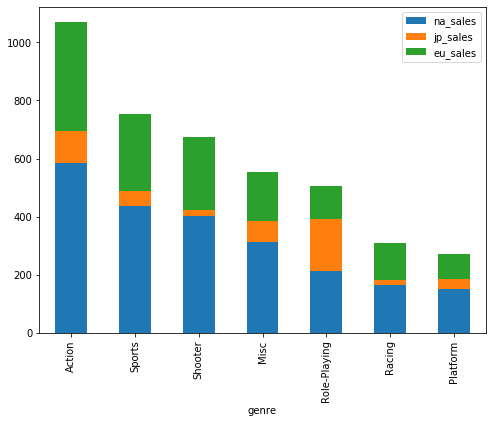

In [ ]:
# For each region (NA, EU, JP), determine: The top five genres. Explain the difference.
naGenres = naData.groupby('genre').sum().sort_values(by='na_sales',ascending=False)
jpGenres = jpData.groupby('genre').sum().sort_values(by='jp_sales',ascending=False)
euGenres = euData.groupby('genre').sum().sort_values(by='eu_sales',ascending=False)
totalGenres = np.unique(np.array(naGenres.reset_index().head(5)['genre'].tolist()+jpGenres.reset_index().head(5)['genre'].tolist()+euGenres.reset_index().head(5)['genre'].tolist()))

regionGenres = pd.merge(naGenres, jpGenres, how='inner', on='genre')
regionGenres = pd.merge(regionGenres, euGenres, how='inner', on='genre')
regionGenres = regionGenres.query('genre in @totalGenres')
regionGenres.plot(kind='bar',stacked=True, figsize=(8,6))

#Do ESRB ratings affect sales in individual regions?

The top 5 genres for NA are action, sport, shooter, misc, role-playing, the top 5 genres for JP are role-playing, action, misc, sport, platform, the top 5 genres for EU are action, sport, shooter, misc, racing. 
@ reviewer- same issue in this one

### Examine whether ratings affect sales in each region.

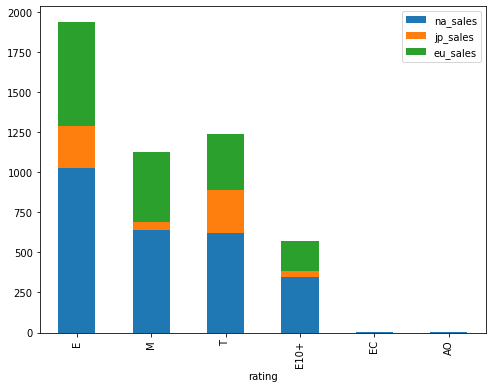

In [ ]:
# For each region (NA, EU, JP), Do ESRB ratings affect sales in individual regions?
naRatings = naData.groupby('rating').sum().sort_values(by='na_sales',ascending=False)
jpRatings = jpData.groupby('rating').sum().sort_values(by='jp_sales',ascending=False)
euRatings = euData.groupby('rating').sum().sort_values(by='eu_sales',ascending=False)
totalRatings = np.unique(np.array(naRatings.reset_index().head(5)['rating'].tolist()+jpRatings.reset_index().head(5)['rating'].tolist()+euRatings.reset_index().head(5)['rating'].tolist()))

regionRatings = pd.merge(naRatings, jpRatings, how='inner', on='rating')
regionRatings = pd.merge(regionRatings, euRatings, how='inner', on='rating')
regionRatings = regionRatings.query('rating in @totalRatings')
regionRatings.plot(kind='bar',stacked=True, figsize=(8,6))


### Test whether the average user ratings of the Xbox One and PC platforms are the same. 

In [ ]:
# Test hypothesis: Average user ratings of the Xbox One and PC platforms are the same.

# Query Xbox One user ratings
xboxOneData = data[data['platform'] == 'XOne']

# drop Nans
xboxOneData = xboxOneData[xboxOneData['user_score'].notna()]

# calculate average
xboxOneAverageUserRating = xboxOneData['user_score'].mean().round(decimals=2)
print('The average user rating of XBox One is: ' + str(xboxOneAverageUserRating) + "/10")

# query PC user rating
pcData = data[data['platform'] == 'PC']

# drop Nans
pcData = pcData[pcData['user_score'].notna()]

# calculate average
pcAverageUserRating = pcData['user_score'].mean().round(decimals=2)
print('The average user rating of PC is: ' + str(pcAverageUserRating) + "/10")

# perform a t-test
results = st.ttest_ind(xboxOneData['user_score'], pcData['user_score'], equal_var=False)
p_value = results.pvalue
alpha = 0.05

if p_value < alpha:
    print('Reject H0')
else:
    print('Cannot reject H0')

The average user rating of XBox One is: 6.63/10
The average user rating of PC is: 6.89/10
Reject H0


In [ ]:
xboxOneData['critic_score'].isna().sum()

7

We want to test the hypothesis that the average user rating of the Xbox One and PC platforms are the same. We can do this using an independent samples t-test to compare the means from the two groups (XBox One user ratings and PC user ratings. We can apply a t-test here due to the Central Limit Theorem, which impliees that you can estimate the mean of a statistical population using the mean of a sample, and since the means are approximately normally distributed - we can use the t-test.

Null Hypothesis H0: The average user rating of XBox One is the same as the average user rating of PC. 
Alternative Hypothesis H1: The average user rating of XBox One is not the same as the average user rating of PC. 

The p_value suggests that we should reject the null hypothesis, thus indicating that the average user rating of XBox One and PC platforms do differ enough to be statistically significant. This means that the sample results have a rare outcome and therefore it is very unlikely that to be just a lucky significance. This can be further proven by looking at the numbers: the average user rating of XBox one is 6.63/10 and the average user rating of PC is 6.89/10 - a 0.26 difference.

### Test whether the average user ratings of the Action and Sports genres are the same. 

In [ ]:
# Test hypothesis: Average user ratings for the Action and Sports genres are different.

# Query action genre user ratings
actionData = data[data['genre'] == 'Action']

# drop Nans
actionData = actionData[actionData['user_score'].notna()]

# calculate average
actionAverageUserRating = actionData['user_score'].mean().round(decimals=2)
print('The average user rating of Action genre is: ' + str(actionAverageUserRating) + "/10")

# query sport genre user rating
sportData = data[data['genre'] == 'Sports']

# drop Nans
sportData = sportData[sportData['user_score'].notna()]

# calculate average
sportAverageUserRating = sportData['user_score'].mean().round(decimals=2)
print('The average user rating of Sports genre is: ' + str(sportAverageUserRating) + "/10")

# perform a t-test
results = st.ttest_ind(actionData['user_score'], sportData['user_score'], equal_var=False)
p_value = results.pvalue
alpha = 0.05

if p_value < alpha:
    print('Reject H0')
else:
    print('Cannot reject H0')

The average user rating of Action genre is: 6.93/10
The average user rating of Sports genre is: 6.55/10
Reject H0


We want to test the hypothesis that the average user rating of the Action genre and Sport genres are different. We can do this using an independent samples t-test to compare the means from the two groups (Action genre user ratings and Sport genre user ratings. We can apply a t-test here due to the Central Limit Theorem, which impliees that you can estimate the mean of a statistical population using the mean of a sample, and since the means are approximately normally distributed - we can use the t-test.

Null Hypothesis H0: The average user rating of Action genre is the same as the average user rating of Sport Genre. 
Alternative Hypothesis H1: The average user rating of Action genre is different than the average user rating of Sport Genre. 

The p_value suggests that we should reject the null hypothesis, thus indicating that the average user rating of Action genre and Sports genre do differ enough to be statistically significant. This means that the sample results have a rare outcome and therefore it is very unlikely that to be just a lucky significance. This can be further proven by looking at the numbers: the average user rating of Action genre is 6.93/10 and the average user rating of PC is 6.55/10 - a 0.55 difference.